# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [125]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [123]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [124]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [39]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [62]:
err = []
LRs = []
for N in N_grid:
    #pass # Place your code here
    idx = np.random.randint(0, X.shape[0], N)
    LR = lm.LinearRegression()
    LR.fit(X[idx], y[idx])
    y_pred = LR.predict(X)

    err.append(np.mean((y_pred - y_gt)**2))
    LRs.append(LR.fit(X[idx], y[idx]))

Код для построения графиков:

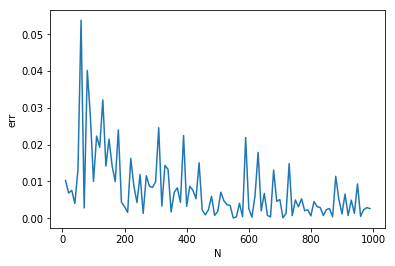

In [63]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

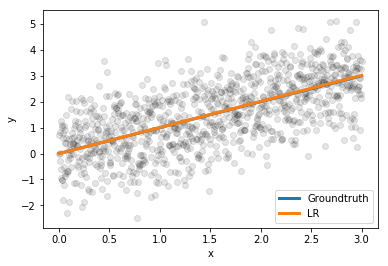

In [64]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [65]:
print(N_grid[np.argmin(err)])
#размер выборки, при которой регрессионая прямая визуально неотличима от истинной (наименьшая ошибка)

550


Проделайте тоже самое для KNN при n_neighbors=3.

In [76]:
from sklearn.neighbors import KNeighborsRegressor as knr
err = []
KNNs = []

for N in N_grid:
    #pass # Place your code here
    idx = np.random.randint(0, X.shape[0], N)
    classifier = knr(3)
    classifier.fit(X[idx], y[idx])
    y_pred = classifier.predict(X)

    err.append(np.mean((y_pred - y_gt)**2))
    KNNs.append(classifier.fit(X[idx], y[idx]))

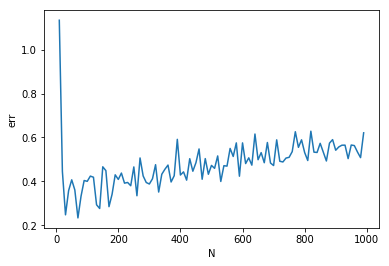

In [77]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

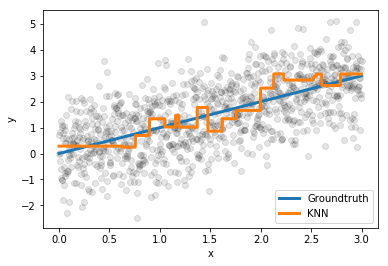

In [68]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [69]:
print(N_grid[np.argmin(err)])
#размер выборки, при которой регрессионая кривая наиболее близка к истинной (наименьшая ошибка)

20


Увеличте число соседей до 10 и проделайте тоже самое.

In [78]:
err = []
KNNs = []

for N in N_grid:
    #pass # Place your code here
    idx = np.random.randint(0, X.shape[0], N)
    classifier = knr(10)
    classifier.fit(X[idx], y[idx])
    y_pred = classifier.predict(X)

    err.append(np.mean((y_pred - y_gt)**2))
    KNNs.append(classifier.fit(X[idx], y[idx]))

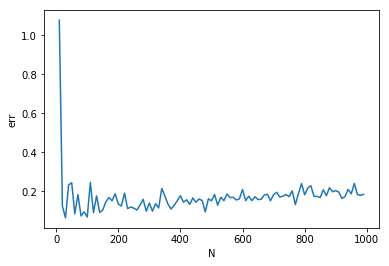

In [79]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

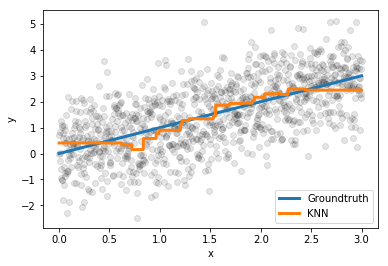

In [80]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [81]:
print(N_grid[np.argmin(err)])
#размер выборки, при которой регрессионая прямая визуально неотличима от истинной (наименьшая ошибка)

30


Какие выводы можно сделать?

При использовании линейной регрессии среднеквадратичная ошибка в целом уменьшается при увеличении выборки. Размер выборки, при которой регрессионная прямая (линейная регрессия) визуально неотличима от истинной - 550. При использовании метода k ближайших соседей ошибка сначала резко уменьшается, а затем растёт с небольшой скоростью, достигая минимума на небольших выборках (в конкретном эксперименте: 20 при 3 и 30 при 10 соседях). Кроме того, бОльшая точность в данном случае обеспечивается бОльшим числом соседей. В обоих методах величина ошибки существенно колеблется при изменении числа наблюдений (что объясняется их случайным характером), однако линейная регрессия аппроксимирует истинную зависимость более точно.

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        Poly = pp.PolynomialFeatures(degree=d_new)
        X_new = Poly.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

При увеличении размера выборки величина ошибка становится примерно одинаковой и небольшой как для линейной регрессии, так и для регрессий с полиномиальными признаками (см. первый график). Однако при использовании полиномиальных признаков ошибка всё же ниже (второй график), что объясняется нелинейностью истинной зависимости. Также регрессия с полиномиальными признаками степени 2 приближает истинную зависимость немного лучше, чем с признаками степени 5, вероятно, при степени 5 алгоритм начинает переобучаться.

In [84]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [167]:
err_1 = []
LRs_1 = []
for N in N_grid:
    #pass # Place your code here
    idx = np.random.randint(0, X.shape[0], N)
    clf = lm.LinearRegression()
    clf.fit(X[idx], y[idx])
    y_pred_1 = clf.predict(X)

    err_1.append(np.mean((y_pred_1 - y_gt)**2))
    LRs_1.append(clf_1.fit(X[idx], y[idx]))

err_2 = []
LRs_2 = []
#pass # Преобразуйте признаки в полиномиальные степени 2
import sklearn.preprocessing as pp
Poly = pp.PolynomialFeatures(degree=2)
X_new_2 = Poly.fit_transform(X)

for N in N_grid:
    #pass # Place your code here
    idx = np.random.randint(0, X_new_2.shape[0], N)
    clf = lm.LinearRegression()
    clf.fit(X_new_2[idx], y[idx])
    y_pred_2 = clf.predict(X_new_2)

    err_2.append(np.mean((y_pred_2 - y_gt)**2))
    LRs_2.append(clf.fit(X_new_2[idx], y[idx]))

err_3 = []
LRs_3 = []
#pass # Преобразуйте признаки в полиномиальные степени 5
Poly = pp.PolynomialFeatures(degree=5)
X_new_3 = Poly.fit_transform(X)
for N in N_grid:
    #pass # Place your code here
    idx = np.random.randint(0, X_new_3.shape[0], N)
    clf = lm.LinearRegression()
    clf.fit(X_new_3[idx], y[idx])
    y_pred_3 = clf.predict(X_new_3)

    err_3.append(np.mean((y_pred_3 - y_gt)**2))
    LRs_3.append(clf.fit(X_new_3[idx], y[idx]))

Код для построения всех графиков:

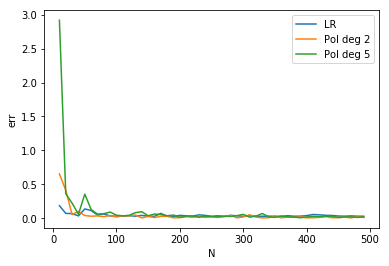

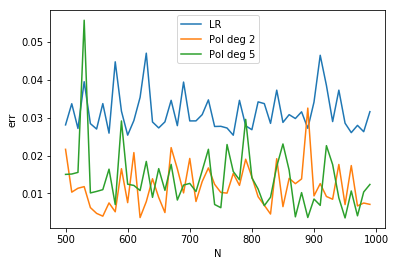

In [168]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

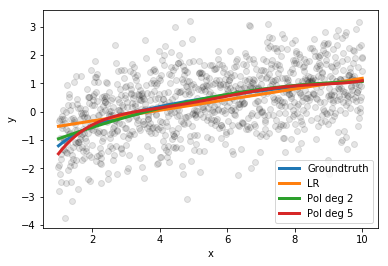

In [169]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

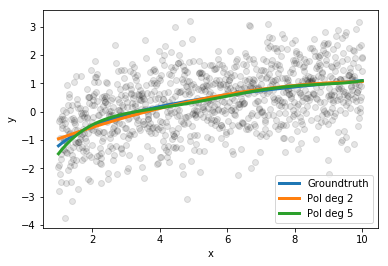

In [170]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

И линейная, и Ridge регрессия имеют приблизительно одинаковые и небольшие среднеквадратичные ошибки, однако у Ridge ошибка незначительно меньше. В целом, обе регрессии хорошо приближают истинную зависимость. Коэффициенты параметров меньше у Ridge регрессии, в чём проявляется её способность уменьшать слишком большие веса, за счёт чего и достигается большая точность.

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = Ridge.predict(X_train)

In [137]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [138]:
pass # Place your code here
LR = lm.LinearRegression()
LR.fit(X, y)
y_pred_LR = LR.predict(X)

Ridge = lm.Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)

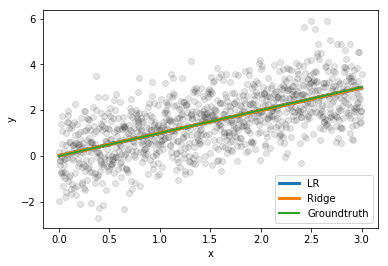

In [139]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

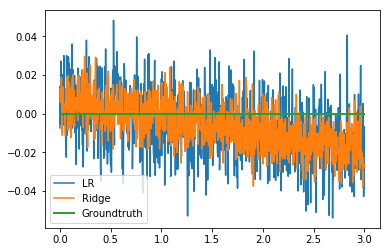

In [140]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [141]:
print(np.mean((y_pred_LR - y_gt)**2))
print(np.mean((y_pred_Ridge - y_gt)**2))

0.000302971446503
0.000181428526226


In [143]:
print(LR.coef_)
print(Ridge.coef_)

[[ 1.23708435 -0.09380266 -0.01942929]]
[[ 0.89951214  0.06677481 -0.01419909]]


#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

В регрессии Lasso коэффициенты при первом и втором признаке становятся нулевыми (таким образом, зависимыми признаками здесь наоборот являются 1 и 2, а независимыми - 3 и 4), что демонстрирует её умение отбирать ЛНЗ признаки. В Ridge регрессии все признаки имеют веса, она хуже справляется с линейной зависимостью. Соответственно, в регрессии Lasso явное уменьшение размерности данных происходит за счёт зануления части признаков.

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = Lasso.predict(X_train)

In [189]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [190]:
pass # Place your code here
Ridge = lm.Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)

Lasso = lm.Lasso()
Lasso.fit(X, y)
y_pred_Lasso = Lasso.predict(X)

In [191]:
print(Lasso.coef_)
print(Ridge.coef_)

[ 0.          0.          0.15333557  0.06132268]
[[ 1.01174243  1.02105037 -0.02242831 -0.01339789]]


## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [144]:
import pandas as pd

In [145]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [146]:
data = data.iloc[:,5:]

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

При обучении линейной регрессии коррелирующие признаки будут искажать истинные значения коэффициентов. В предложенном датасете многие признаки не коррелируют или коррелируют между собой слабо (розовый цвет на heatmap), однако есть и признаки с очень сильной корреляцией. Тем не менее, можно считать влияние скоррелированных признаков на точность модели линейной регрессии небольшим.

Для визуализации можно использовать seaborn.heatmap()

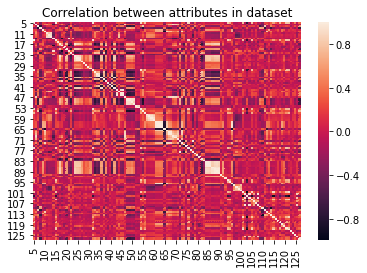

In [166]:
pass # Place your code here
import seaborn as sns
sns.heatmap(data.corr('pearson'))
plt.title("Correlation between attributes in dataset")
plt.show()

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

49 55


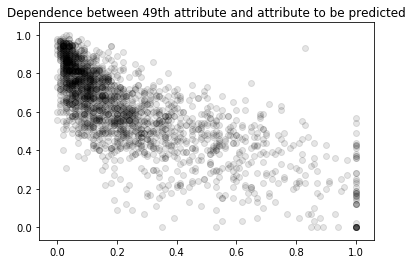

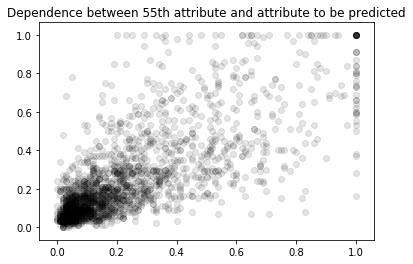

In [162]:
pass # Place your code here
min_c = np.argmin(data.corr('pearson')[127])
max_c = np.argmax(data.corr('pearson')[127][:-1])
print(min_c, max_c)
plt.title('Dependence between 49th attribute and attribute to be predicted')
plt.scatter(data[127], data[min_c], c="black", alpha=0.1)
plt.show()
plt.title('Dependence between 55th attribute and attribute to be predicted')
plt.scatter(data[127], data[max_c], c="black", alpha=0.1)
plt.show()

#### 3. Постройте гистограмму распределения предсказываемого значения.

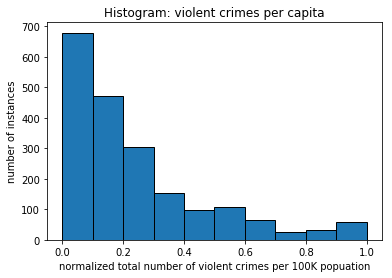

In [169]:
pass # Place your code here
plt.title('Histogram: violent crimes per capita')
plt.xlabel('normalized total number of violent crimes per 100K popuation')
plt.ylabel('number of instances')
plt.hist(data[127], edgecolor = 'black')
plt.show()

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [170]:
pass # Place your code here
data = data.fillna(data.mean())

Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [171]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [172]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [173]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [244]:
pass # Place your code here
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_pred = LR.predict(X_test)

err = np.mean((y_pred - y_test)**2)
print(err)

0.01896435558358197


#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [245]:
pass # Place your code here
from sklearn.model_selection import GridSearchCV as gscv

Lasso = lm.Lasso()
Ridge = lm.Ridge()
alphas = np.logspace(-4, -0.5, 30)

clf1 = gscv(Lasso, [{'alpha': alphas}], scoring='neg_mean_squared_error')
clf1.fit(X_train_new, y_train_new)
alpha_lasso = clf1.best_params_['alpha']
print(alpha_lasso)

clf2 = gscv(Ridge, [{'alpha': alphas}], scoring='neg_mean_squared_error')
clf2.fit(X_train_new, y_train_new)
alpha_ridge = clf2.best_params_['alpha']
print(alpha_ridge)

0.00017433288222
0.316227766017


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

В Ridge регрессии все признаки имеют веса (очень маленькие и близкие по значениям), а в регрессии Lasso большинство коэффициентов нулевые. Регрессия Lasso производит отбор признаков, создавая более простую модель, поэтому можно предположить, что многие признаки в данных влияют на результаты слабо (и, возможно, не влияют вообще, а в регрессии Ridge имеют вес только для компенсации других незначимых признаков).

In [264]:
Ridge = lm.Ridge(alpha = alpha_ridge)
Ridge.fit(X_train_new, y_train_new)
print(Ridge.coef_)

Lasso = lm.Lasso(alpha = alpha_lasso)
Lasso.fit(X_train_new, y_train_new)
print(Lasso.coef_)

[-0.10337462  0.01659185  0.19124837 -0.03043278 -0.00135343  0.0784432
 -0.019339   -0.10661837 -0.11359052  0.02539493 -0.16963292  0.04999219
 -0.00199084 -0.13606474  0.0374612  -0.22955156  0.12389752  0.02291312
 -0.06478405  0.10018347 -0.032719   -0.25184713 -0.01581955 -0.05148678
  0.03785641  0.04301711  0.0125267  -0.05702321 -0.14947158 -0.10348862
  0.04247814  0.13645017  0.0023876   0.1824967  -0.07572024 -0.020689
  0.07113206 -0.00159113  0.13779071  0.21859464 -0.05931875 -0.06816229
 -0.00925223 -0.04307489 -0.18673793 -0.05827494  0.00200252  0.04886672
 -0.16283513  0.04957839  0.18881853 -0.08966623  0.04061958 -0.00360247
 -0.02555144 -0.01161908 -0.07427694  0.01879653  0.08690962  0.03692598
 -0.03172732 -0.18198171 -0.15199663  0.03286015  0.31904384 -0.15518949
 -0.14618437 -0.13736024  0.19408493  0.01615027  0.04328761  0.29233258
 -0.0222079   0.08968188  0.06311545 -0.06557245 -0.00610048  0.04995898
 -0.0070741  -0.12896907  0.04611948  0.08867408 -0.23

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

Средняя ошибка увеличилаась как для Ridge, так и для Lasso регрессии. Таким образом, переменные, которые регрессия Lasso сочла незначимыми, всё же вносят вклад в модель и их включение увеличивает её точность. Кроме того, ошибка регрессии Lasso на отобранных признаках гораздо больше, чем ошибки остальных регрессоров - вероятно, это связано с тем, что регрессия продолжает отбирать "нерелевантные" признаки, и начинает убирать всё больше значимых.

In [282]:
#pass # Place your code here
coeff = Lasso.coef_ != 0
idxs = []
for i in range(len(coeff)):
    if coeff[i]: idxs.append(i)

X_train_2 = X_train_new[idxs]
X_test_2 = X_test.iloc[idxs]
y_train_2 = y_train_new[idxs]
y_test_2 = y_test.iloc[idxs]

Ridge = lm.Ridge(alpha = alpha_ridge)    
Ridge.fit(X_train_new, y_train_new)
y_pred_r1 = Ridge.predict(X_test)
err_r1 = np.mean((y_test-y_pred_r1)**2)

Ridge = lm.Ridge(alpha = alpha_ridge)
Ridge.fit(X_train_2, y_train_2)
y_pred_r2  = Ridge.predict(X_test_2)
err_r2 = np.mean((y_pred_r2 - y_test_2)**2)

Lasso = lm.Lasso(alpha = alpha_lasso)    
Lasso.fit(X_train_new, y_train_new)
y_pred_l1 = Lasso.predict(X_test)
err_l1 = np.mean((y_test-y_pred_l1)**2)

Lasso = lm.Lasso(alpha = alpha_lasso)
Lasso.fit(X_train_2, y_train_2)
y_pred_l2 = Lasso.predict(X_test_2)
err_l2 = np.mean((y_pred_l2 - y_test_2)**2)
print(err_r1, err_l1) #all
print(err_r2, err_l2) #non-zero

0.0178255407437904 0.017698017628053158
0.026662879322977093 0.06312035387467169


C:\Users\umakrinova\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [103]:
pass # Place your code here
from sklearn.neighbors import KNeighborsRegressor as knr

clf = knr(3)
clf.fit(X_train_new, y_train_new)
y_pred = clf.predict(X_test)
err = np.mean((y_pred - y_test)**2)
print(err)

0.02526091030789825


#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [283]:
pass # Place your code here
neighbours = np.arange(1, 20, 1)
p = np.array([1, 2])
params = [{'n_neighbors': neighbours, 'p': p}]

clf_gscv = gscv(knr(), params, scoring='neg_mean_squared_error')
clf_gscv.fit(X_train_new, y_train_new)
n_knn = clf_gscv.best_params_['n_neighbors']
p_knn = clf_gscv.best_params_['p']
print(n_knn, p_knn)

11 1


С помощью какого алгоритма удалось достичь лучшего качества?

С помощью GridSearch удалось достичь меньшей среднеквадратичной ошибки, чем при использовании KNN на трёх соседях со стандартными параметрами.

In [242]:
clf = knr(n_neighbors = n_knn, p = p_knn)
clf.fit(X_train_new, y_train_new)
y_pred_gscv = clf.predict(X_test)
err = np.mean((y_pred_gscv - y_test)**2)
print(err)

0.018276758687643148


Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

В исследованном датасете большое количество признаков, причём многие из них являются малозначимыми для построения модели и даже интуитивно кажутся не слишком информативными. Также существенна доля скоррелированных признаков, особенно можно отметить признаки, сильно скоррелированные с предсказываемым значением и, соответственно, вносящие большой вклад в предсказательные способности моделей (хотя у большиства признаков попарная корреляция всё же небольшая). Кроме того, распределение значений предсказываемого признака, как видно из построенной выше гистограммы, не является нормальным, а ближе к гиперболическому.
Для исследования датасета были использованы инструменты предварительной обработки данных pandas, средства визуализации matplotlib, функции numpy и sklearn.linear_model. Была обучена стандартная линейная регрессия, регресии Ridge и Lasso со стандартными гиперпараметрами, с подбором alpha с помощью GridSearch и они же на признаках, отобранных регрессией Lasso как значимые. Также было оценено качество предсказания KNN на трёх соседях и при выборе числа соседей и p с помощью GridSearch. Наименьшую ошибку дало использование регрессии Lasso с подбором alpha, однако и регрессия Ridge и KNN с подбором гиперпараметров дали близкие и небольшие ошибки. Однако KNN работает на большой выборке гораздо дольше, поэтому я бы предпочла использовать регрессию Lasso или Ridge с подбором гиперпараметров, поскольку различия в среднеквадратичной ошибке между ними можно считать незначимыми, однако точность моделей всегда увеличивалась при использовании GridSearch (что логично). В т.ч. на мой выбор влияет то, что метод, дающий наименьшую ошибку (среди использующих gridSearch), менялся при повторном проведении эксперимента (это объясняется случайной природой ошибок).

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [ ]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    
    #alpha_grid - массив перебираемых значений гиперпараметра
    #alpha - найденное оптимальное значение гиперпараметра 
    #err - массив среднеквадратичных отклонений для каждого из alpha_grid
    
    return alpha, err, alpha_grid

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])

Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

In [ ]:
plt.plot(alpha_grid, err)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])

In [ ]:
plt.plot(alpha_grid, err)
plt.show()

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

In [ ]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])